In [1]:
import os
os.getcwd()
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is c:\Users\blond\Documents\NssProjects\sleigh_the_model


changed model slightly to make this graph

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scripts.features as ft 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pandas as pd
import scripts.features as ft
import scripts.model_vis as md
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import  Lasso
import numpy as np

In [3]:
file = 'data/dataformodel.csv'
months_in_adv = 12
data = ft.load_data(file, months_in_adv)

In [6]:
features_to_lag = [
    'pce',
    'inflation',
    'unemployment_rate',
    'revolving_credit',
    'nonrevolving_credit',
    'total_credit'
]

In [7]:
data_with_lag = ft.add_lag_features(data, months_in_adv, features_to_lag)
data_with_lag = data_with_lag.dropna()
X = data_with_lag.drop(columns=['date', 'pce_future'])
y = data_with_lag['pce_future']

In [8]:
test_size = 60
min_train_size = 60
total_months = len(data_with_lag)
max_splits = (total_months - min_train_size) // test_size
print(max_splits)
n_splits = max_splits

11


In [9]:
time_series_split = TimeSeriesSplit(
    n_splits = n_splits,
    test_size = test_size
)

In [10]:
lasso =  Lasso(alpha=0.1, max_iter=10000)

In [11]:
lasso_mse_scores, lasso_r2_scores, lasso_test_results = md.train_eval_model_vis(X, y, lasso, time_series_split, data_with_lag, months_in_adv)

In [12]:
lg = LinearRegression() 
lr_mse_scores, lr_r2_scores, lr_test_results = md.train_eval_model_vis(X, y, lg, time_series_split, data_with_lag, months_in_adv)

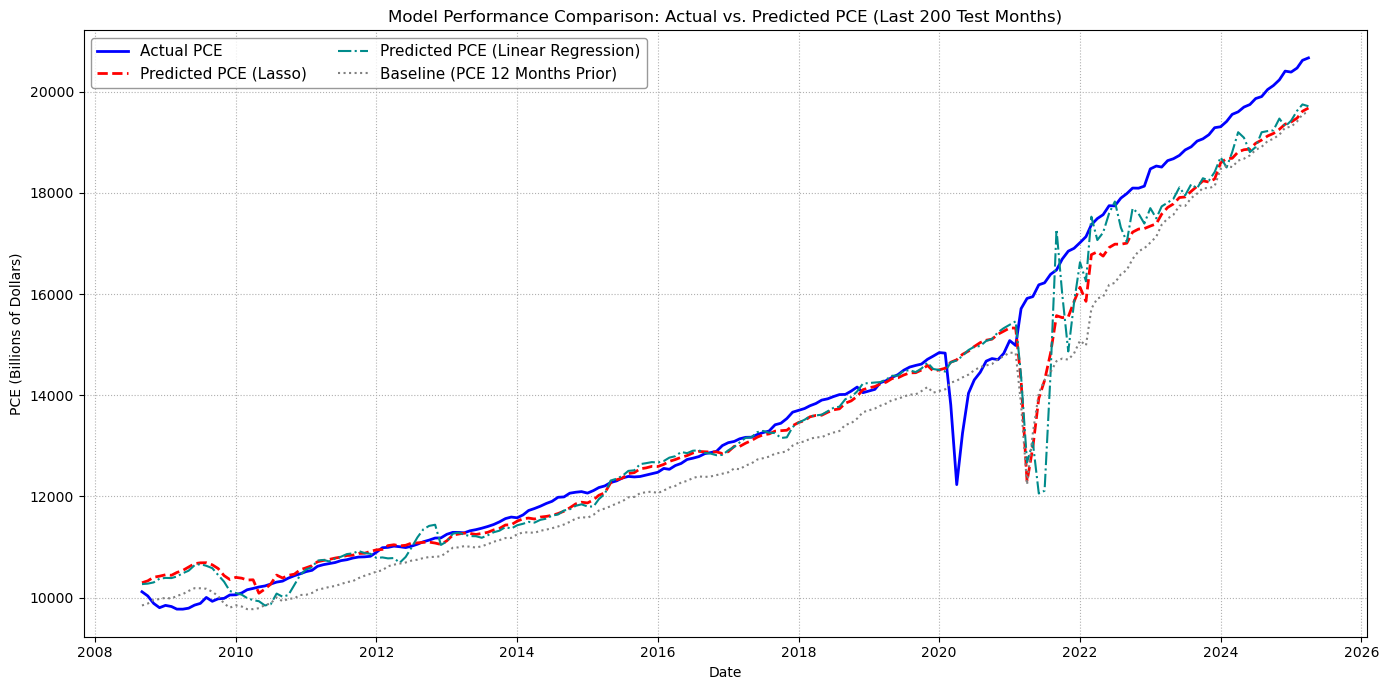

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

all_lasso_test_predictions_df = pd.concat(lasso_test_results)
last_lasso_test_results_df = all_lasso_test_predictions_df.tail(200).copy()

all_lr_test_predictions_df = pd.concat(lr_test_results)
last_lr_test_results_df = all_lr_test_predictions_df[all_lr_test_predictions_df['date'].isin(last_lasso_test_results_df['date'])].copy()
last_lr_test_results_df = last_lr_test_results_df.rename(columns={'predicted_pce': 'predicted_pce_lr'}) 

last_lasso_test_results_df = last_lasso_test_results_df.sort_values('date')
last_lr_test_results_df = last_lr_test_results_df.sort_values('date')


plt.figure(figsize=(14, 7))

plt.plot(last_lasso_test_results_df['date'], last_lasso_test_results_df['actual_pce'], label='Actual PCE', color='blue', linewidth=2)

plt.plot(last_lasso_test_results_df['date'], last_lasso_test_results_df['predicted_pce'], label='Predicted PCE (Lasso)', color='red', linestyle='--', linewidth=2)

plt.plot(last_lr_test_results_df['date'], last_lr_test_results_df['predicted_pce_lr'], label='Predicted PCE (Linear Regression)', color='darkcyan', linestyle='-.', linewidth=1.5)

plt.plot(last_lasso_test_results_df['date'], last_lasso_test_results_df['baseline_pce'], label='Baseline (PCE 12 Months Prior)', color='grey', linestyle=':', linewidth=1.5)

plt.title('Model Performance Comparison: Actual vs. Predicted PCE (Last 200 Test Months)')
plt.xlabel('Date')
plt.ylabel('PCE (Billions of Dollars)')
plt.legend(loc='upper left', ncol=2, fontsize=11, frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('visuals/model_compare.png', dpi = 300)
plt.show()